In [26]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys

sys.path.append("../")
sys.path.append("../..")
from util import *
from model.pinn import *

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = sin
# BC:u(0, t) = u(2π, t)

# 构造burgers

无粘Burgers方程: u_t + u*u_x = 0, [-1, 1]*[0, 0.5]

IC:u(x, 0) = 1, x<=0; u(x, 0) = -1, x>0

BC:u(0, t) = u(2π, t)

points:  (201, 201, 2)
u shape:  (201, 201)


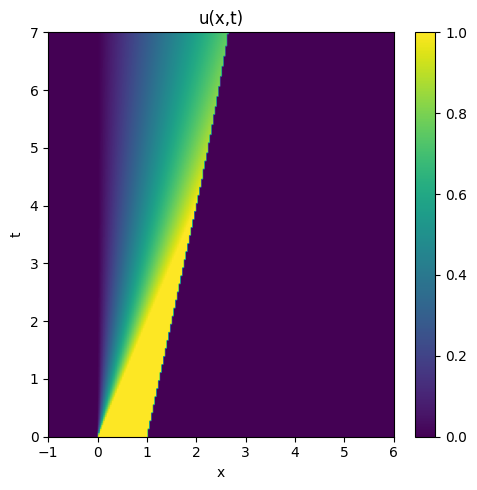

In [27]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[0,X]*[0,T]区域采样
    x = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)

    return data

def get_burgers(x, t, c):
    if t <= 2/c:
        if x < 0:
            return 0
        elif 0 < x < c * t:
            return x / (c * t)
        elif c * t < x < 1 + c*t / 2:
            return 1
        else:
            return 0
    else:
        if 0 < x < np.sqrt(2*c*t):
            return x / (c * t)
        else:
            return 0


X_SIZE = 201
T_SIZE = 201
c = 0.5

data = get_data([-1, 6], [7, 0], X_SIZE, T_SIZE)  # (1001, 701, 2)
print('points: ', data.shape) 
# 计算解
u = np.zeros((T_SIZE, X_SIZE))
print('u shape: ', u.shape)
for i in range(X_SIZE):
    for j in range(T_SIZE):
        u[j, i] = get_burgers(data[j, i, 0], data[j, i, 1], c)



# x = data[..., 0]
# t = data[..., 1]
# print(x.shape)

# u = get_burgers(x, t)
# print(u.shape)

plt.figure(figsize=(5,5))
plt.imshow(u, extent=[-1,6,0,7], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# # 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# # 使用 scipy.io.savemat 保存为 .mat 文件
scipy.io.savemat('burgers_c_0.5.mat', data_dict)

(201, 201)


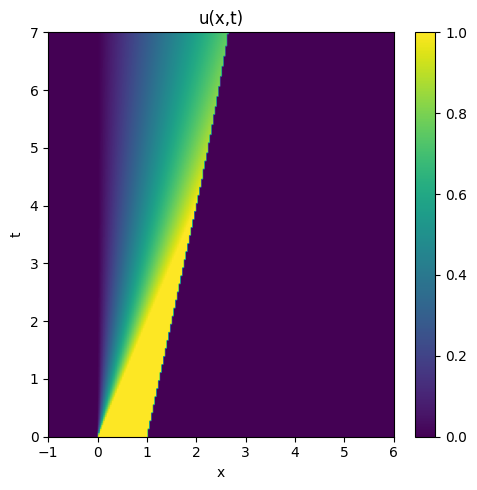

In [28]:
path = '/home/pengguohang/python_test/HCL/pinnsformer/demo/Burgers_competition_2/burgers_c_0.5.mat'

data = scipy.io.loadmat(path)
u = data['u']
print(u.shape)
plt.figure(figsize=(5,5))
plt.imshow(u, extent=[-1,6,0,7], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 模型

In [29]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[x_range]*[y_range]区域采样
    x = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    
    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_init = data[0,:,:]  # 初始时刻
    b_end = data[-1,:,:]
    b_left = data[:,0,:]
    b_right = data[:,-1,:]
    res = data.reshape(-1,2)

    return res, b_init, b_end, b_left, b_right

res, _, _, _, _ = get_data([-1, 7], [10, 0], 201, 201) 
res = torch.tensor(res, dtype=torch.float32, requires_grad=True)
x_res, t_res = res[:,0:1], res[:,1:2]
print(x_res.shape, t_res.shape)

torch.Size([40401, 1]) torch.Size([40401, 1])


In [30]:
acti = 'Tanh'
model = Resnet(in_dim=2, hidden_dim=128, out_dim=1, num_layer=4, acti=acti)

u = model(x_res, t_res) 

# 采样


In [31]:
from scipy.stats import qmc
import numpy as np

def sampleCubeQMC(dim, l_bounds, u_bounds, expon=100):
    '''Quasi-Monte Carlo Sampling

    Get the sampling points by quasi-Monte Carlo Sobol sequences in dim-dimensional space. 

    Args:
        dim:      The dimension of space
        l_bounds: The lower boundary
        u_bounds: The upper boundary
        expon:    The number of sample points will be 2^expon

    Returns:
        numpy.array: An array of sample points
    '''
    sampler = qmc.Sobol(d=dim, scramble=False)
    sample = sampler.random_base2(expon)
    data = qmc.scale(sample, l_bounds, u_bounds)
    data = np.array(data)
    return data[1:]


data = sampleCubeQMC(3, [-1, -1, 0], [1, 1, 1], 2)  # 2^n - 1个点
print(data)
data = sampleCubeQMC(3, [-1, -1, 0], [1, 1, 1], 1)  # 2^n - 1个点
print(data)

[[ 0.    0.    0.5 ]
 [ 0.5  -0.5   0.25]
 [-0.5   0.5   0.75]]
[[0.  0.  0.5]]


In [32]:
import torch
x = torch.rand(100) * 7 -1
t = torch.rand(100) * 7
res = torch.stack((x, t), dim=-1)
print(res.shape)
print(t)

torch.Size([100, 2])
tensor([3.8789, 0.0151, 5.8721, 4.4230, 2.3705, 3.1573, 5.8315, 6.5561, 0.8713,
        5.0122, 4.1304, 2.0562, 6.9027, 0.3442, 0.3110, 5.2929, 3.8411, 4.1764,
        3.8038, 4.9785, 4.4442, 0.9821, 1.8344, 2.4348, 3.9412, 6.6554, 6.2670,
        4.4483, 0.6281, 3.1501, 3.1501, 4.1865, 6.2118, 3.2322, 6.0229, 1.2506,
        2.5521, 3.4102, 5.4505, 1.8674, 2.6356, 0.8664, 6.4864, 1.9377, 4.3772,
        4.6022, 4.9944, 0.1556, 3.2062, 3.6891, 0.8598, 1.1644, 6.6268, 4.9643,
        5.0677, 3.1221, 4.7394, 2.4988, 4.0022, 3.9549, 5.4223, 6.5541, 5.0202,
        4.9499, 0.5269, 6.7803, 3.8284, 6.2716, 0.8907, 3.4750, 3.8207, 0.3685,
        1.6858, 6.0832, 6.6189, 6.2740, 1.1181, 1.0165, 0.6367, 5.3531, 3.3548,
        1.2217, 6.2796, 3.3515, 4.0564, 2.3416, 4.0973, 5.5568, 1.5055, 1.6355,
        1.4535, 4.4580, 6.1216, 5.5982, 1.1038, 1.5423, 1.1885, 1.3679, 0.9228,
        3.6283])


In [33]:
import numpy as np

# 设置随机数种子以确保结果可复现（可选）
np.random.seed(0)

# 生成500个随机数，区间为[0, 7]
residuals1 = np.random.uniform(0, 7, 10)
print(residuals1)

# 生成500个随机数，区间为[-1, 6]
residuals2 = np.random.uniform(-1, 6, 10)

# 合并两个区间的随机数
residuals = np.concatenate((residuals1, residuals2))

# 打印生成的随机数
print(residuals)

[3.84169453 5.00632556 4.21934363 3.81418228 2.9655836  4.52125879
 3.06311048 6.24241101 6.74563932 2.68409063]
[ 3.84169453  5.00632556  4.21934363  3.81418228  2.9655836   4.52125879
  3.06311048  6.24241101  6.74563932  2.68409063  4.54207527  2.70226444
  2.97631193  5.47917647 -0.50274759 -0.3900949  -0.85847122  4.82833892
  4.44709726  5.09008504]


In [38]:
x = [[[1,2,3], [4,5,6]]]
x =  torch.tensor(x, dtype=torch.float32, requires_grad=True)
print(x.shape)
y = 2*x + x

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
print(dy_x.shape, dy_x)

torch.Size([1, 2, 3])


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.